# Resilient Distributed Dataset (RDD)

Recall: 

- **Iterative Distributing Computing** i.e process data over multiple jobs in computations: fairly common to reuse / share data among multiple jobs and may also want to do multiple ad-hoc queries over a shared dataset

- Apache Spark >> Hadoop (MapReduce): faster execution in iterative algorithms


- Hadoop Problem: 
    + the only way to resue data between computations (2 MapReduce jobs) is to store data in an intermediate stable distributed store / external stable storage system (e.g. HDFS, Amazon S3)
    + Slower overall computations of jobs: Involves multiple replications, serializations in the process
    + Spend 90% of the time doing HDFS read-write operations
    

- RDD: enable fault-tolerant distributed in-memory computations

## What is RDD?

- **Definition**: Immutable distributed collections of records that can be operated on in parallel.


- **Why RDDS?** Current computing frameworks handle inefficiently: 

    1. iterative algorithms: ML and graph computations
    2. interactive data mining tools: ad-hoc queries on the same dataset


- **Goal**:  
    Reuse intermediate in-memory results across multiple data-intensive workloads with no need for copying large amounts of data over the network.


- **Name decomposition:** 
    + Resilient: fault-tolerant, able to recompute missing / damaged partitions due to node failures
    + Distributed: distributed with data residing multiple nodes in a cluster
    + Dataset: collection of paritioned data with primitive values or values of values (e.g. tuples)    
    
    
- Each dataset in RDD is divded into logical partitions, which will be computed on different nodes of the cluster
- It stores the state of memory as an object across the jobs and the object is sharable between the jobs
- Data sharing in memory is 10-100x faster than network and disk


## RDDs Key Properties

#### 1. Distributed

- Divided into >=1 partitions and distributed as in-memory collections of objects across multiple nodes in a cluster

#### 2. Immutable

- Read-only: Once created, they never change
- can only be transformed using transformations to new RDDs

#### 3. Resilient

- Automatically rebuilt on failure: Able to recompute missing or damaged partitions due to node failures
- RDDs track lineage info to rebuild lost data (instead of replication)

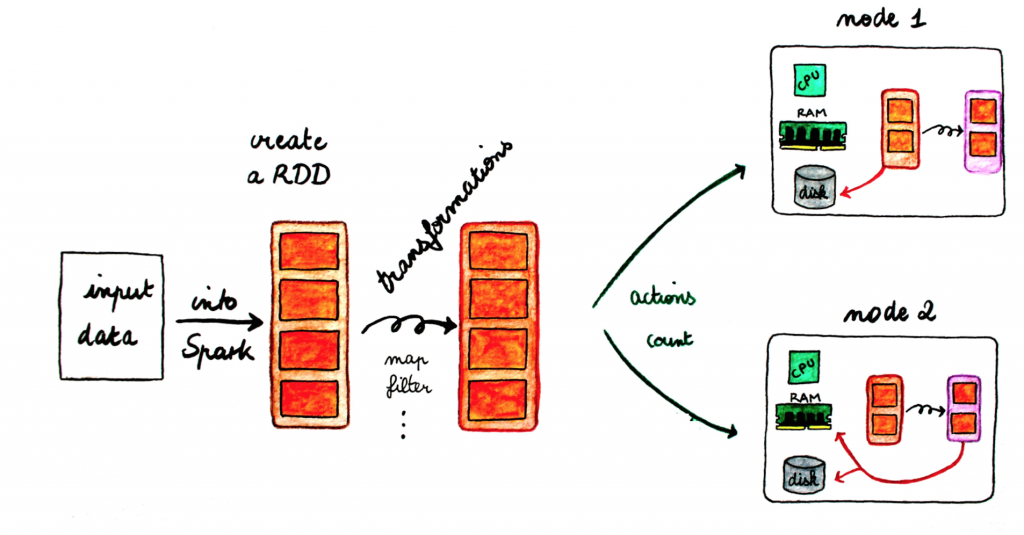

In [12]:
from IPython.display import Image
Image("http://www.duchess-france.org/wp-content/uploads/2015/06/global_view-1024x535.png")

1. To the left, the input data comes from an external storage. The data are loaded into Spark and an RDD is created.
2. The big orange box represents an RDD with its partitions (small orange boxes). You can chain transformations on RDDs. As the transformations are lazy, the partitions will be sent across the nodes of the cluster when you will call an action on the RDD.
3. Once a partition is located on a node, you can continue to operate on it.

N.B: all operations made on RDDs are registered in a DAG (direct acyclic graph): this is the lineage principle. In this way if a partition is lost, Spark can rebuilt automatically the partition thanks to this DAG.

src: http://www.duchess-france.org/starting-with-spark-in-practice/

## Other Properties

- In-Memory: data inside RDD is stored in memory as much (size) and long (time) as possible.
- Lazy evaluated: the data inside RDD is not available or transformed until an action is executed that triggers the execution
- Parallel: process data in parallel
- Typed: RDD records have types, e.g. Long in RDD[Long] or (Int, String) in RDD[(Int, String)].
- Partitioned: records are partitioned (split into logical partitions) and distributed across nodes in a cluster.
- Location-Stickines: RDD can define placement preferences to compute partitions (as close to the records as possible).

## RDDs Creation

1. Load an external data
    - Reference a dataset in an external storage system (e.g. HDFS, HBS, etc.)
2. Parallelize an existing collection in your driver program
    - Take a collection (e.g. `Array` or `List`), create RDDs from its element and distribute to Spark executors in the process

In [2]:
from pyspark import SparkContext
sc = SparkContext.getOrCreate()

In [1]:
sc

<SparkContext master=local[*] appName=PySparkShell>

In [2]:
# METHOD 1 - LOAD EXTERNAL DATA
# read a text file from HDFS, a local file system (available on all nodes)
# return it as an RDD of Strings, default partitions=2
lines = sc.textFile('./data/README.md')

In [9]:
# METHOD 2 - PARALLELIZE
# you can specify how many partitions you want, default partitions=4
lines = sc.parallelize(['spark', 'spark is fun', '1', '2', '3', '4', '5', '6'], numSlices=4)

In [10]:
lines.getNumPartitions()

4

In [11]:
# only show which elements are contained in RDD as 1 whole list
# very expensive method
lines.collect()

['spark', 'spark is fun', '1', '2', '3', '4', '5', '6']

In [12]:
# glom() shows the actual partition within the RDD
lines.glom().collect()

[['spark', 'spark is fun'], ['1', '2'], ['3', '4'], ['5', '6']]

## `Lambda` Expression

- Define function inline
- Create an anomynous function using the lambda keyword at runtime

In [13]:
def f(x):
    return x+2
f(2)

4

In [14]:
g = lambda x: x+2
g(2)

4

## RDD operations

1. Transformations: create new dataset from an existing
2. Actions: return a value to the driver pgroam after runnning a computation on the dataset

### Transformations

+ Take one RDD and **return a new RDD**
+ Do not mutate the existing RDD
+ Produce a new RDD by performing data manipulation on another RDD
+ Ex: 
    + map, flatMap, filter
    + mapPartitions, mapPartitionsWithIndex
    + sample, union, intersection, distinct, groupByKey, reduceByKey, aggregateByKey, sortByKey, join, cogroup, cartesian, pipe, coalesce, repartition, repartitionAndSortWithinPartitions.
+ **Lazy evaluation**: Computation doesn't take place until the action is triggered / Spark will not begin to execute until it sees an action
    + e.g. when we call `sc.textFile()`, the data is not loaded until necessary
    + use lazy evaluation to reduce the number of passes it has to take over our data by grouping operations together
+ Spark keeps track of the set of dependencies between different RDDs, called the *lineage graph*. 
    + It uses this information to compute each RDD on demand and to *recover lost data* if part of a persistent RDD is lost

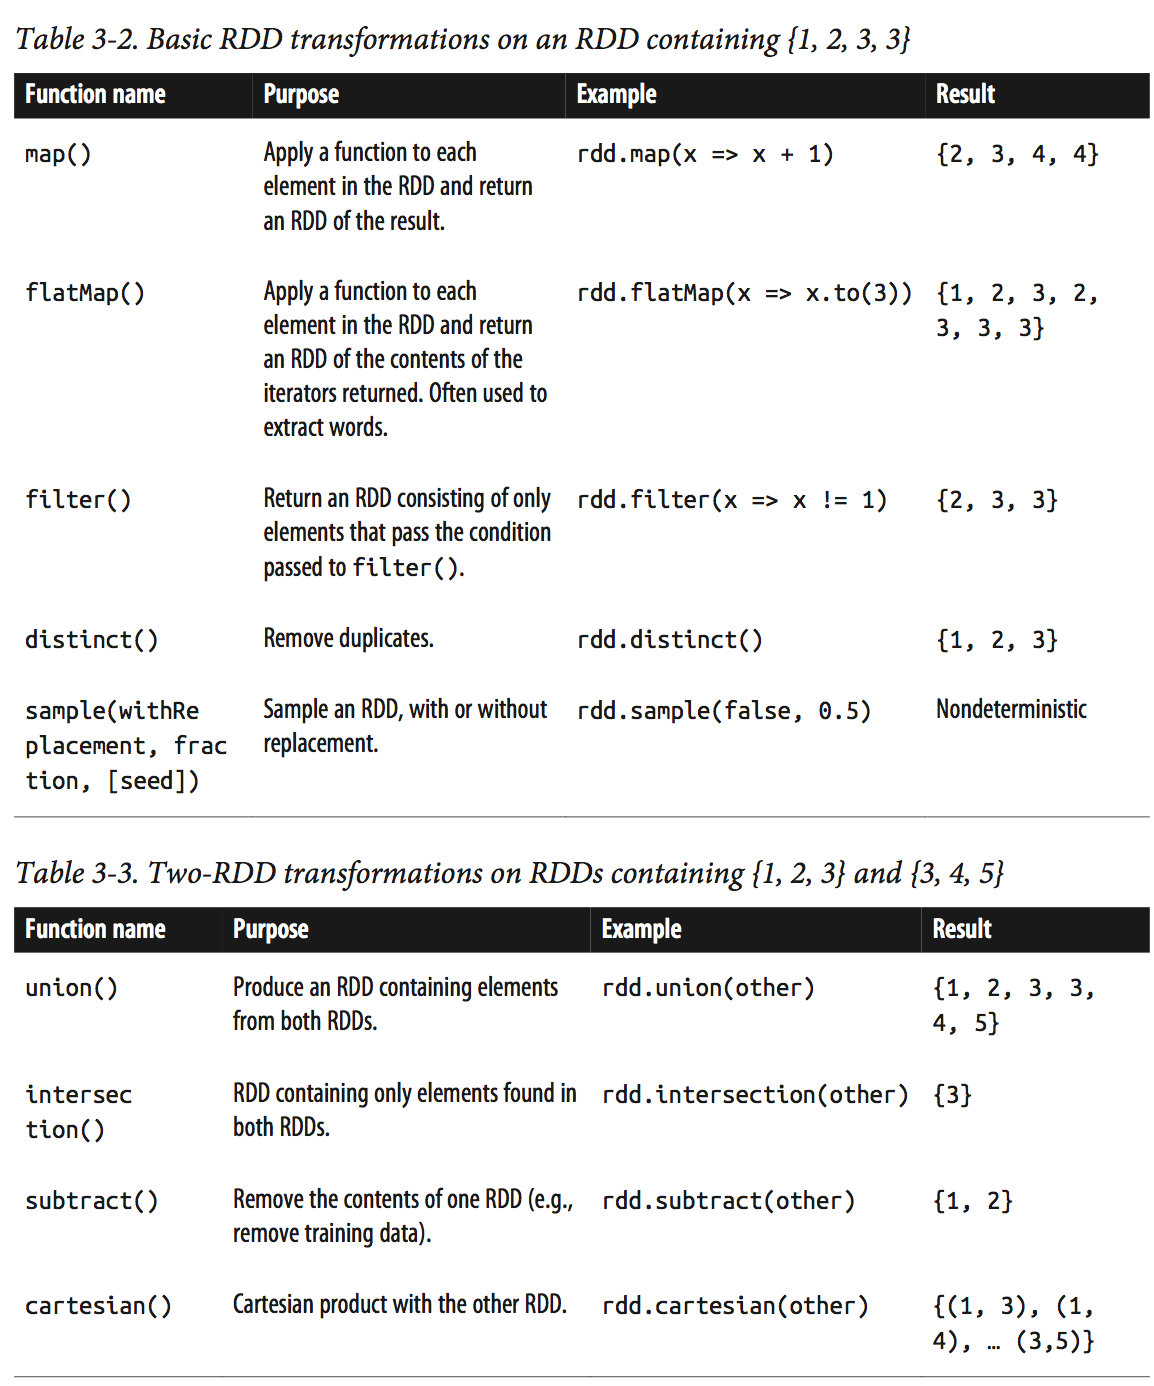

In [14]:
Image('/Users/ThyKhueLy/Downloads/rdd_transform.png')

**Element-wise Transformation**

+ `map(func)`: apply function to each element in the RDD, return a list of lists
    + accepts function(s) as argument(s)
    + `func` will be applied to the source RDD and eventually each elements of the source RDD and will create a new RDD as a resulting values
    + example: `map(lambda x: x.split())`
    + one-to-one transformation, transforms each element of a collection into one element of the resulting collection
    + create a connection per element, computationally expensive

+ `flatMap(func)`: 
    + one-to-many transformation, transform each element to >=0 elements
    + returns a list of elements as an iterator
        + rather than producing an RDD of iterators, we get back an RDD that consists of the elements from all of the iterators
    + func should return a Seq rather than a single item


+ `filter(func)`: return an RDD that passes the filtering requirement.

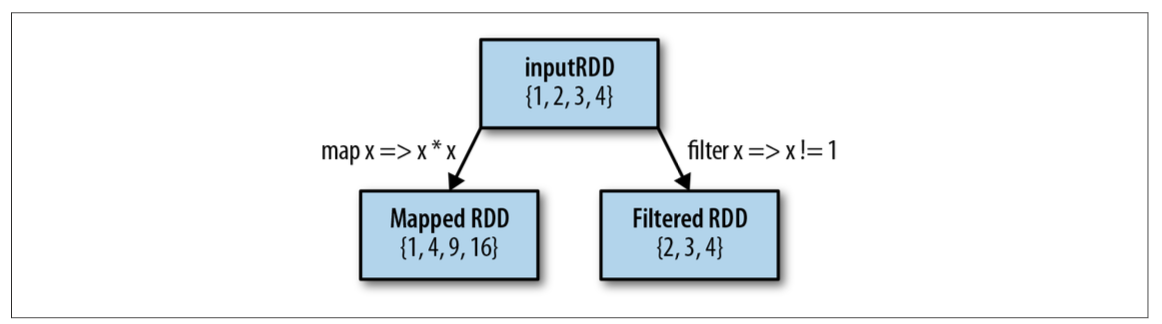

In [13]:
Image('/Users/ThyKhueLy/Downloads/map_filter.png')

In [16]:
lines = sc.textFile('./data/ignatian_pedagogy.txt')

In [17]:
lines.collect()[:4]

[u'= Ignatian Values =',
 u'The University of San Francisco enjoys a distinguished heritage and Jesuit tradition.  At the core of this tradition are transcendent values, including the integration of learning, faith and service; care for the whole person; character and conviction; religious truth and interfaith understanding; and a commitment to building a more just world.  The key values of this Jesuit tradition are as follows:',
 u'***********************************************************************************',
 u"1. Contemplative in Action - St. Ignatius Loyola believed that prayer and reflectivity should so guide our choices and actions that our activity itself becomes a way of entering into union with and praising God.  Being a contemplative in action also means seeing beyond the superficial in life to appreciate the mystery, beauty, and sacredness of all life.  It is a means of seeing God in all things and in everyone.  Contemplation is a critical dimension of the spiritual l

### Example 1-1: Split line by space

In [18]:
# Example 1-1: Split line by space
# return a list of lists, each list is a list of words
words = lines.map(lambda line: line.split())

In [19]:
words.collect()[:2]

[[u'=', u'Ignatian', u'Values', u'='],
 [u'The',
  u'University',
  u'of',
  u'San',
  u'Francisco',
  u'enjoys',
  u'a',
  u'distinguished',
  u'heritage',
  u'and',
  u'Jesuit',
  u'tradition.',
  u'At',
  u'the',
  u'core',
  u'of',
  u'this',
  u'tradition',
  u'are',
  u'transcendent',
  u'values,',
  u'including',
  u'the',
  u'integration',
  u'of',
  u'learning,',
  u'faith',
  u'and',
  u'service;',
  u'care',
  u'for',
  u'the',
  u'whole',
  u'person;',
  u'character',
  u'and',
  u'conviction;',
  u'religious',
  u'truth',
  u'and',
  u'interfaith',
  u'understanding;',
  u'and',
  u'a',
  u'commitment',
  u'to',
  u'building',
  u'a',
  u'more',
  u'just',
  u'world.',
  u'The',
  u'key',
  u'values',
  u'of',
  u'this',
  u'Jesuit',
  u'tradition',
  u'are',
  u'as',
  u'follows:']]

### Example 1-2: A list of words within one level structure

In [10]:
# Example 1-2: a list of words within one level structure
words_flat = lines.flatMap(lambda line: line.split()).distinct()
words_flat.collect()[:10]

[u'1981,',
 u'all',
 u'just',
 u'Father',
 u'actions',
 u'discovered',
 u'schools',
 u'including',
 u'ecumenical',
 u'human']

### Example 1-3: Find words including "USF"

In [36]:
# Example 1-3: find the words containting USF
words_flat = lines.flatMap(lambda line: line.split())
words_with_USF = words_flat.filter(lambda word : "USF" in word)
words_with_USF.collect()

[u"USF's", u'USF', u"USF's", u"USF's", u'USF', u'USF', u'USF', u'USF']

In [40]:
# using map - return the lists that have USF
words = lines.map(lambda line: line.split())
lines_with_USF = words.filter(lambda w : "USF" in w)
len(words.collect()), len(lines_with_USF.collect())

(17, 3)

**Partition-wise Transformation**
- `mapPartitions(func)`: 
    + iteration, behave like a for-loop
    + is called once for each Partition unlike `map()` which is called for each element in the RDD  
    + e.g. having 100k elements in a particular RDD partition, `map()` will fire off 100k mapping transformation while for `mapPartition()`, we will pass all 100k records and get all responses in one function calls
    + FASTER than `map()`    


- `mapPartitionsWithIndex(func)`:
    + return a new RDD by applying a function to each partition of the RDD, while tracking the index of the original partition.    

### Example 2-1

In [3]:
# Parallelize numbers between 1 and 16
# Calculate the count and sum in each partition
numbers = sc.parallelize(range(1,17), numSlices=3)

In [4]:
numbers.glom().collect()

[[1, 2, 3, 4, 5], [6, 7, 8, 9, 10], [11, 12, 13, 14, 15, 16]]

In [5]:
def count_sum(nums):
    count_sum = [0,0]
    for num in nums:
        count_sum[0] +=1
        count_sum[1] +=num
    # return count_sum will return one whole list    
    return [count_sum]

In [6]:
partition_count_sum = numbers.mapPartitions(count_sum)
partition_count_sum.collect()

[[5, 15], [5, 40], [6, 81]]

In [7]:
# note if lambda x: sum(x) returns an error
sum_all = numbers.mapPartitions(lambda x: [sum(x)])
sum_all.glom().collect()

[[15], [40], [81]]

**Set Operations**
- Format : `rdd1.operator(rdd2)`
- Examples: 
    - `distinct()`: Return only one of each element - **expensive** as it requires shuffling all the data over the network
    - `union()`: If there are duplicated elements, it returns all duplicates
    - `intersection()`: Return common elements
    - `subtract()`: Return elements that are in rdd1 only
    - `cartesian()`: Return cartesian product (all pairs between rdd1 and rdd2) - **very expensive** for large RDDs

### Example 3-1: Find distinct words

In [1]:
# example 3-1
# find distinct words in “ignatian_pedagogy"
lines1 = sc.textFile('./data/ignatian_pedagogy.txt', minPartitions=5)
words1 = lines1.flatMap(lambda line: line.split())
distinctW1 = words1.distinct()
distinctW1.collect()[:10]

[u'seeing',
 u'own',
 u'"Cura',
 u'Valencia,',
 u'enriched',
 u'character',
 u'St.',
 u'suggests',
 u'engaged',
 u'reflected']

### Example 3-2 Find distinct words

In [2]:
# example 3-2
# create a flatmap of distinct words from “README.md”
lines2 = sc.textFile('./data/README.md', minPartitions=6)
words2 = lines2.flatMap(lambda line: line.split())
distinctW2 = words2.distinct()
distinctW2.collect()[:10]

[u'detailed',
 u'./bin/run-example',
 u'package.',
 u'##',
 u'when',
 u'library',
 u'documentation,',
 u'R,',
 u'through',
 u'against']

### Example 3-3: Union, Intersection, Subtract

In [3]:
# example 3-3-1: union=joining 2 lists
union12 = distinctW1.union(distinctW2)
print (lines1.getNumPartitions(), distinctW1.getNumPartitions()) 
print (lines2.getNumPartitions(), distinctW2.getNumPartitions())
print (union12.getNumPartitions())

(5, 5)
(6, 6)
11


In [4]:
union12.collect()[:10]

[u'seeing',
 u'own',
 u'"Cura',
 u'Valencia,',
 u'enriched',
 u'character',
 u'St.',
 u'suggests',
 u'engaged',
 u'reflected']

In [5]:
# example 3-3-2: intersection=common elements
intersect12 = distinctW1.intersection(distinctW2)
intersect12.collect()
#intersect12.getNumPartitions()

[u'is',
 u'have',
 u'rich',
 u'learning,',
 u'and',
 u'other',
 u'in',
 u'its',
 u'more',
 u'particular',
 u'The',
 u'on',
 u'the',
 u'an',
 u'It',
 u'are',
 u'to',
 u'core',
 u'that',
 u'with',
 u'way',
 u'by',
 u'including',
 u'should',
 u'building',
 u'a',
 u'this',
 u'first',
 u'different',
 u'same',
 u'or',
 u'from',
 u'no',
 u'also',
 u'through',
 u'for',
 u'be',
 u'This',
 u'of']

In [6]:
intersect12.glom().collect()[:10]

[[u'is', u'have', u'rich', u'learning,'],
 [u'and', u'other'],
 [u'in', u'its', u'more', u'particular', u'The', u'on', u'the'],
 [u'an', u'It'],
 [u'are', u'to', u'core', u'that', u'with'],
 [u'way', u'by'],
 [],
 [u'including', u'should', u'building', u'a', u'this', u'first'],
 [u'different', u'same', u'or'],
 [u'from', u'no', u'also']]

In [7]:
# example 3-3-3: subtract=different elements
subtract12 = distinctW1.subtract(distinctW2)
subtract12.getNumPartitions()

11

In [8]:
subtract12.collect()[:10]

[u'"Men',
 u'community',
 u'service;',
 u'itself',
 u'Contemplative',
 u'meaning.',
 u'Jesuit',
 u'Diversity',
 u'top',
 u'projects;']

In [9]:
# example 3-3-4: cartesian=cross product
cart12 = distinctW1.cartesian(distinctW2)
cart12.getNumPartitions()

30

In [10]:
cart12.collect()[:10]

[(u'seeing', u'detailed'),
 (u'seeing', u'./bin/run-example'),
 (u'seeing', u'package.'),
 (u'seeing', u'##'),
 (u'seeing', u'when'),
 (u'seeing', u'library'),
 (u'seeing', u'documentation,'),
 (u'seeing', u'R,'),
 (u'seeing', u'through'),
 (u'seeing', u'against')]

### Actions

+ trigger a computation to return the result to the calling program or to perform some actions on an RDD’s elements.
+ return non-RDD objects
+ Ex. reduce, fold, aggregate, collect, count, first, take, takeSample, takeOrdered, saveAsTextFile, countByValue, foreach


- `reduce(func)`: combines the elements of the RDD together in parallel
    + reduces the elements of this RDD using the specified commutative and associative binary operator
    + accepts a function (which accepts >=2 arguments and returns a single element)
    + the function should be **Commutative** and **Associative** in mathematical nature
    + can still run with 1 element
    + **return a ValueError with an empty RDD**

- `fold(zeroValue)(func)`:
    + Take a function with the same signature as needed for reduce(). 
    + Take a “zeroValue” to be used for the initial call on each partition
    + The zeroValue will be added for each partition, and then added one more time to the output
    + In short, it will be 
    
            reduce(func) + zeroValue * numPartitions + zeroValue
            
    + Returns a new element of the same type
    + **`reduce` does not work when the RDD is empty, since fold is giving an intial value, we can avoid an error raising by an empty set** (e.g. use 1 for multiplying or 0 for sum)

- `aggregate(zeroValue)(seqOp, combOp)`:
    + Supply an initial zero value of the type we want to return.
    + `seqOp` : Function to combine the elements from the RDD with the accumulator. Runs once in a partition.
    + `combOp` : Function to merge two accumulators, given that each nodes accumulates its own results locally.
    + The seqOp will run once for every record in a partition. This will result in a resulting object for each partition. The combOp will be used to merge all the resulting objects together.
    + Can return an element of a different type.

In [4]:
num = sc.parallelize(range(1,9), numSlices=4)
num.glom().collect()

[[1, 2], [3, 4], [5, 6], [7, 8]]

In [37]:
reduce_sum = num.reduce(lambda x,y: x+y)
print (reduce_sum)

36


### Example 4: Reduce, Fold & Aggregate

In [26]:
# Example 4-1
# num between 1-9, calculate sum of odd numbers
nums = sc.parallelize(range(1,10), numSlices=3)
odd_nums = nums.filter(lambda x: x%2 != 0)
odd_nums.glom().collect()

[[1, 3], [5], [7, 9]]

In [27]:
print odd_nums.reduce(lambda x,y: x-y)

-5


In [28]:
# Example 4-2: Use fold
print odd_nums.fold(0, lambda x,y: x+y)
print odd_nums.fold(1, lambda x,y: x+y)  # (1+3)+1 + (5)+1 + (7+9+11)+1 = 5+6+28 = 39 => 39+1 = 40
print odd_nums.fold(2, lambda x,y: x+y) # (1+3)+2 + (5)+2 + (7+9+11)+2 = 6+7+29 = 42 => 42+2 = 44

25
29
33


In [30]:
# Example 4-3: Use aggregate
print odd_nums.glom().collect()
print odd_nums.aggregate(
    (0,0), # tuple of initial values which is the acc
    (lambda acc, value: (acc[0]+value, acc[1]+1)),
    (lambda acc1, acc2: (acc1[0]+acc2[0], acc1[1]+acc2[1]))
    )

[[1, 3], [5], [7, 9]]
(25, 5)


**Handy Numeric Action Types**
- count(), mean(), sum(), max(), min(), variance(), stddev()
- format: `rdd.function()`

In [28]:
odd_nums.sum()

25

In [29]:
odd_nums.variance()

8.0

More examples: 

- `collect()`: Return the entire RDD’s contents
    + your entire dataset must fit in memory on a single machine to use collect() on it, so collect() shouldn’t be used on large datasets
    

- `count()`: Return the count of elements
- `countByValue()`: Return the number of times each element occurs in the RDD
- `top(n)`: Return top elements from an RDD, using the default ordering on the data. **DESCENDING** order, work with string as well
- `take(n)`: Return n elements (randomly?) - may represent a biased collection.
- `first()`: Return the first element of the data.
    + Note: `take(1)` returns an array with the only element as the first element and first() returns the element as itself e.g. number/string -> ['a'] vs. 'a'
    
    
- `takeSample(withReplacement, num, seed)`: Return a fixed-size sample subset of an RDD.
    + `sample(withReplacement, fraction, seed)`: Transformation
    
        + fraction: when replacement=T (1) exepcted number of times each element is going to be sampled (2) probablity each element is going to be sampled 
    + `sample` vs. `takeSample`:  Return a fixed sample subset of an RDD as an **array**, not RDD
    
- `foreach()`: Used for performing computations on each element in the RDD.

### Example 5-1

In [32]:
x = sc.parallelize([3,4,1,2], 3)
y = sc.parallelize(range(2,6), 2)
z = x.union(y)
z.glom().collect()

[[3], [4], [1, 2], [2, 3], [4, 5]]

In [33]:
# count
z.count()

8

In [34]:
# return a dictionary - work like Counter
z.countByValue()

defaultdict(int, {1: 1, 2: 2, 3: 2, 4: 2, 5: 1})

In [37]:
z.top(5)

[5, 4, 4, 3, 3]

In [12]:
z.take(2)

[3, 4]

In [13]:
z.take(10)

[3, 4, 1, 2, 2, 3, 4, 5]

In [14]:
print z.takeSample(withReplacement=False, num=10, seed=2)
print z.takeSample(withReplacement=True, num=10, seed=2)

[2, 4, 1, 2, 3, 3, 4, 5]
[1, 1, 1, 5, 4, 5, 2, 1, 2, 1]


In [42]:
z.sample(withReplacement=True, fraction=0.5, seed=2).glom().collect()

[[], [4], [1], [2, 3], [5]]

In [41]:
def pr(x): 
    print (x+1) # not working!!!!
#z.foreach(pr) 
z.foreach(lambda x: pr(x))

### More examples

In [23]:
X = sc.parallelize(range(1, 17), numSlices=3)
Y = sc.parallelize(range(2, 12), numSlices=4)
Z = sc.parallelize([22, 31, 11], numSlices=2)

In [25]:
union_xy = sc.union([X, Y, Z])
print union_xy.glom().collect()

[[1, 2, 3, 4, 5], [6, 7, 8, 9, 10], [11, 12, 13, 14, 15, 16], [2, 3], [4, 5], [6, 7], [8, 9, 10, 11], [22], [31, 11]]


In [27]:
count_per_num = union_xy.countByValue()
print count_per_num, "\n"

# convert a dict to a list of tuples
count_per_num = sc.parallelize(count_per_num.items(), numSlices=1)
print count_per_num.glom().collect()

defaultdict(<type 'int'>, {1: 1, 2: 2, 3: 2, 4: 2, 5: 2, 6: 2, 7: 2, 8: 2, 9: 2, 10: 2, 11: 3, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 22: 1, 31: 1}) 

[[(1, 1), (2, 2), (3, 2), (4, 2), (5, 2), (6, 2), (7, 2), (8, 2), (9, 2), (10, 2), (11, 3), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (22, 1), (31, 1)]]


In [27]:
lines = sc.textFile('./data/ignatian_pedagogy.txt')
words = lines.flatMap(lambda x: x.split()) # will not work with map
words_counter = words.countByValue() # does not return RDD, return dict
words_counter.items()[:10]

[(u'all', 3),
 (u'enrollment.', 1),
 (u'themes', 1),
 (u'religious', 2),
 (u'Today', 1),
 (u'relationships', 1),
 (u'young', 1),
 (u'to', 17),
 (u'Reflecting', 1),
 (u'discovering', 1)]

In [67]:
x = sc.parallelize([1,2, 4,5,6, 1,2,3])
y = sc.parallelize([7,8,9, 1,2, 2,1])
print x.glom().collect()
print y.glom().collect()
inter_xy = x.intersection(y)
inter_xy.glom().collect()

[[1, 2], [4, 5], [6, 1], [2, 3]]
[[7], [8, 9], [1, 2], [2, 1]]


[[], [1], [2], [], [], [], [], []]

In [23]:
people = []
people.append({'name':'Bob', 'age':45,'gender':'M'})
people.append({'name':'Gloria', 'age':43,'gender':'F'})
people.append({'name':'Albert', 'age':28,'gender':'M'})
people.append({'name':'Laura', 'age':33,'gender':'F'})
people.append({'name':'Simone', 'age':18,'gender':'T'})
peopleRdd=sc.parallelize(people)
peopleRdd.glom().collect()

[[{'age': 45, 'gender': 'M', 'name': 'Bob'}],
 [{'age': 43, 'gender': 'F', 'name': 'Gloria'}],
 [{'age': 28, 'gender': 'M', 'name': 'Albert'}],
 [{'age': 33, 'gender': 'F', 'name': 'Laura'},
  {'age': 18, 'gender': 'T', 'name': 'Simone'}]]

In [25]:
# sum up their ages and count them
seqOp = (lambda x,y: (x[0]+y['age'], x[1]+1))
combOp = (lambda x,y: (x[0]+y[0], x[1]+y[1]))
peopleRdd.aggregate((0,0), seqOp, combOp)

(167, 5)

### Run python script in Spark

#### SparkConf 
+ `SparkConf` stores configuration parameters that your Spark driver application will pass to `SparkContext`.
+ These parameters either: 
    + define properties of your Spark driver application or
    + are used by Spark to allocate resources on the cluster

#### SparkContext
+ A heart of a Spark application, sets up configurations & established a connection to a Spark execution evnironment (**represents a connection to a computing cluster**)
+ Allows your Spark driver application to access the cluster through a resource manager (e.g. YARN)
+ Once it's created, you can use it to create distributed entities (e.g. RDDs, accumulators), access Spark services and run jobs until `SparkContext` is stopped

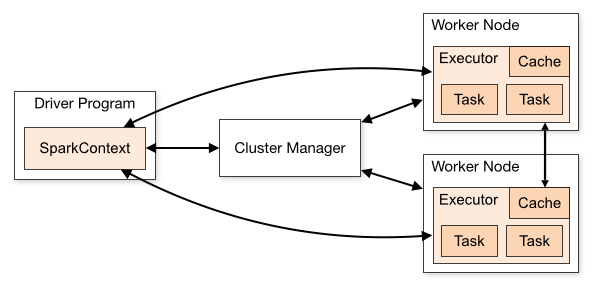

In [67]:
Image('https://msdnshared.blob.core.windows.net/media/MSDNBlogsFS/prod.evol.blogs.msdn.com/CommunityServer.Blogs.Components.WeblogFiles/00/00/01/61/78/metablogapi/3566.091415_1429_Understandi1.png')

Python file:

```python
from pyspark import SparkConf, SparkContext

# create SparkConf object to configure the application
conf = SparkConf().setMaster(“local[*]).setAppName(“AppName”)

# initialize a SparkContext (SC)
sc = SparkContext(conf = conf) 

# your code
lines=sc.textFile('./data/README.md')  # load data
print(lines.count())  
print(lines.first()) 

# close Spark
sc.stop()
```

Terminal:

```bash
# unset your environment variables
$unset PYSPARK_DRIVER_PYTHON
$unset PYSPARK_DRIVER_PYTHON_OPTS
$echo $PYSPARK_DRIVER_PYTHON

# run your standalone program
$spark-submit yourscript > output.txt
```